# Figure 1

In [1]:
import os.path as op
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
df_dir = op.join('..', 'data', 'dataframes')

In [3]:
subjects = ['wlsubj004', 'wlsubj007', 'wlsubj023', 'wlsubj045', 'wlsubj061', 
            'wlsubj064', 'wlsubj065', 'wlsubj067', 'wlsubj070']

In [4]:
sns.set_context('notebook', font_scale=1.3)
mpl.rcParams['font.sans-serif'] = ['Arial']

## Training behavior

Load dataframe

In [5]:
learn_behav = pd.read_csv(op.join(df_dir, 'behav_learn_data.csv'))
test_behav = learn_behav.query("block_type=='test'")
test_behav = test_behav.assign(test_block=lambda x: x.block/2)

### Figure 1d

In [6]:
test_behav.groupby('subj')['block'].apply(lambda x: len(np.unique(x))).agg([np.mean, np.min, np.max])

mean    4.333333
amin    4.000000
amax    5.000000
Name: block, dtype: float64

In [7]:
mean_test_behav = test_behav.groupby(['subj', 'block']).mean().reset_index()
mean_test_behav = mean_test_behav[['subj', 'test_block', 'acc_ang', 'acc_stim']]
mean_test_behav = mean_test_behav.melt(id_vars=['subj', 'test_block'], value_vars=['acc_stim', 'acc_ang'], 
                                      var_name='stim_dimension', value_name='acc')
mean_test_behav['stim_dimension'] = mean_test_behav['stim_dimension'].map({'acc_stim': 'pattern', 
                                                                           'acc_ang':  'angle'})

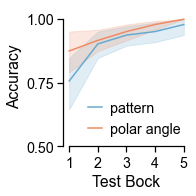

In [8]:
pal = ['#67a9cf', '#ef8a62']

f, ax = plt.subplots(1, 1, figsize=(3,3), sharey=True, sharex=True)
sns.lineplot(x='test_block', y='acc', hue='stim_dimension', 
             palette=pal, ci=95, data=mean_test_behav, ax=ax)
ax.set(ylim=[.5, 1.05], xticks=np.arange(1, 6), ylabel='Accuracy', yticks=[.5, .75, 1], xlabel='Test Bock')
handles, labels = ax.get_legend_handles_labels()

ax.legend(handles, ['pattern', 'polar angle'], frameon=False, loc=[.15, .03], handlelength=1, handletextpad=.5)
sns.despine(trim=True)
f.tight_layout()

### Figure 1e

In [9]:
max_block = test_behav.groupby('subj')['test_block'].max()

test_dist = []
for s, g in test_behav.groupby(('subj')):
    m = max_block[s]
    g = g.query("test_block == 1 | test_block == @m")
    test_dist.append(g)
test_dist = pd.concat(test_dist)

In [10]:
test_dist['ang_dist'] = abs(test_dist['probe_angle'] - test_dist['stim_angle']) 
test_dist['ang_dist'] = test_dist['ang_dist'].map(lambda x: x if x<=180 else 360-x)
test_dist['stim_dist'] = abs(test_dist['probe_freq'] - test_dist['stim_freq'])
test_dist['block'] = 'last'
test_dist.loc[test_dist['test_block'] == 1, 'block'] = 'first'

In [11]:
test_prob = []
for col in ['ang', 'stim']:
    ntrials = test_dist.groupby(['block', col+'_dist']).count()
    ntarget = test_dist.query("{0}=='target'".format('resp_'+col)).groupby(['block', col+'_dist']).count()
    df = ntarget['acc_'+col] / ntrials['acc_'+col]
    df = df.replace({np.nan:0}).reset_index()
    test_prob.append(df)
test_prob = pd.concat(test_prob).reset_index(drop=True)

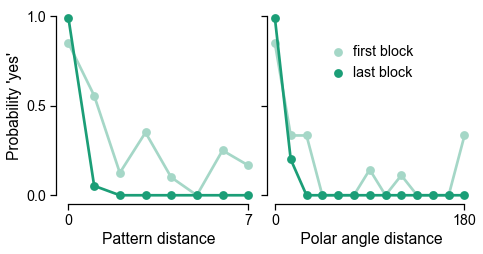

In [12]:
pal = np.array(sns.light_palette('#1b9e77', 4))[[1, 3]]

# Plot pattern
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(7,3.8), sharey=True, sharex=False)
sns.pointplot(x='stim_dist', y='acc_stim', ci=95,  hue='block',
              order=np.arange(0, 8, 1), hue_order=['first', 'last'], palette=pal, 
              data=test_prob, ax=ax1)
ax1.set(xlabel='Pattern distance', xticks=[0, 7], xticklabels=[0, 7], ylabel='Probability \'yes\'')
ax1.legend_ = None

# Plot angle
sns.pointplot(x='ang_dist', y='acc_ang', ci=95, hue='block',
              order=np.arange(0, 195, 15), palette=pal, hue_order=['first', 'last'], 
              data=test_prob, ax=ax2)
ax2.set(xticks=[0, 12], xticklabels=[0, 180], ylabel='',
        xlabel=' Polar angle distance', yticks=[0, .5, 1], ylim=[-.05, 1.05])
handles, labels = ax2.get_legend_handles_labels()
ax2.legend_ = None


ax2.legend(handles[:2], ['first block', 'last block'], handletextpad=0, loc=[.25, .6], frameon=False)
sns.despine(trim=True)
f.tight_layout(w_pad=0)

## Scan behavior

Load dataframe

In [13]:
scan_behav = pd.read_csv(op.join(df_dir, 'behav_scan_data.csv'))

Accuracy on one back task

In [14]:
scan_mean = scan_behav.query("block_type=='perception'&repeat==True").groupby('subj')['acc'].mean()
scan_mean.agg([np.mean, np.min, np.max])

mean    0.868745
amin    0.794118
amax    0.931818
Name: acc, dtype: float64

Percent of each vividness response per subject

In [15]:
tot = scan_behav.query("block_type=='memory'").groupby('subj')['trial'].count()

viv = scan_behav.query("block_type=='memory'").groupby(['subj', 'resp'], dropna=False)['trial'].count().reset_index()
viv = viv.fillna('no_resp')
mem_responses = ['vivid', 'weak', 'no_mem', 'no_resp']
full_index = pd.DataFrame(dict(subj=np.repeat(subjects, len(mem_responses)), resp=mem_responses*len(subjects)))
viv = viv.merge(full_index, on=['subj', 'resp'], how='right').fillna(0)

viv = viv.set_index('subj').join(tot, rsuffix='_total').reset_index()
viv['percent'] = viv.apply(lambda x: x['trial'] / x['trial_total'], axis=1)

In [16]:
viv.groupby(('resp'))['percent'].agg([np.mean, np.min, np.max])

,mean,amin,amax
resp,,,
no_mem,0.005208,0.000000,0.026042
no_resp,0.007523,0.000000,0.036458
vivid,0.897801,0.723958,0.994792
weak,0.089468,0.005208,0.250000
